In [27]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy.stats import ttest_ind
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
train = pd.read_csv("/Users/sara/Documents/training_set.csv")
test = pd.read_csv("/Users/sara/Documents/test_set.csv")

In [3]:
X_data = train.drop(columns=['ra', 'dec', 'class'])
Y_data = train['class']
X_test = test.drop(columns=['ra', 'dec', 'class'])
Y_test = test['class']

In [5]:
# initializing and training Gaussian SVC
svc_Gauss = SVC(C=10, kernel='rbf', gamma=10, probability=True)
svc_Gauss.fit(X_data, Y_data)


SVC(C=10, gamma=10, probability=True)

In [7]:
kfold = KFold(n_splits=10, random_state=300, shuffle=True)

svc_Gauss_results = cross_val_score(svc_Gauss, X_test, Y_test, cv=kfold)
print('Accuracy: %.3f%% (%.3f%%)' % (svc_Gauss_results.mean()*100.0, svc_Gauss_results.std()*100.0))

Accuracy: 96.542% (0.886%)


In [9]:
# initializing and training KNN model
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X_data, Y_data)

KNeighborsClassifier(n_neighbors=40)

In [10]:
kfold = KFold(n_splits=10, random_state=300, shuffle=True)

knn_results = cross_val_score(knn, X_test, Y_test, cv=kfold)
print('Accuracy: %.3f%% (%.3f%%)' % (knn_results.mean()*100.0, knn_results.std()*100.0))

Accuracy: 96.069% (0.912%)


In [13]:
# computing the mean error rates for the 2 best models
svc_Gauss_errate = 1 - svc_Gauss_results
knn_errate = 1 - knn_results

# statistical test of significance
t_value, p_value = ttest_ind(knn_errate, svc_Gauss_errate)

# confidence level for the 2-Tail test
confidence = 1 - p_value/2
print(confidence)

0.8607546479924608


In [14]:
# from Student's t Distribution calculator
# the critical value for 9 degrees of freedom with 86% probability
critical_value = 1.149

if t_value > critical_value:
    print('Null hypothesis is rejected: statistical significance between samples exists')
else:
    print('Null hypothesis is approved: no statistical significance between samples')

Null hypothesis is approved: no statistical significance between samples


In [15]:
# defining best 2 models
model1 = knn
model2 = svc_Gauss

In [19]:
# AUC-ROC Curve
# for trained models 1 and 2

# predict probabilities
pred_prob1 = cross_val_predict(knn, X_test, Y_test, cv=10, method='predict_proba')
pred_prob2 = cross_val_predict(svc_Gauss, X_test, Y_test, cv=10, method='predict_proba')

#pred_prob1 = knn.predict_proba(X_test)
#pred_prob2 = svc_Gauss.predict_proba(X_test)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

In [20]:
# roc curve for model1 for each class
fpr1 = {}
tpr1 = {}
thresh1 ={}

n_class = 3

for i in range(n_class):    
    fpr1[i], tpr1[i], thresh1[i] = roc_curve(Y_test, pred_prob1[:,i], pos_label=i+1)

In [21]:
# roc curve for model2 for each class
fpr2 = {}
tpr2 = {}
thresh2 ={}

n_class = 3

for i in range(n_class):    
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(Y_test, pred_prob2[:,i], pos_label=i+1)

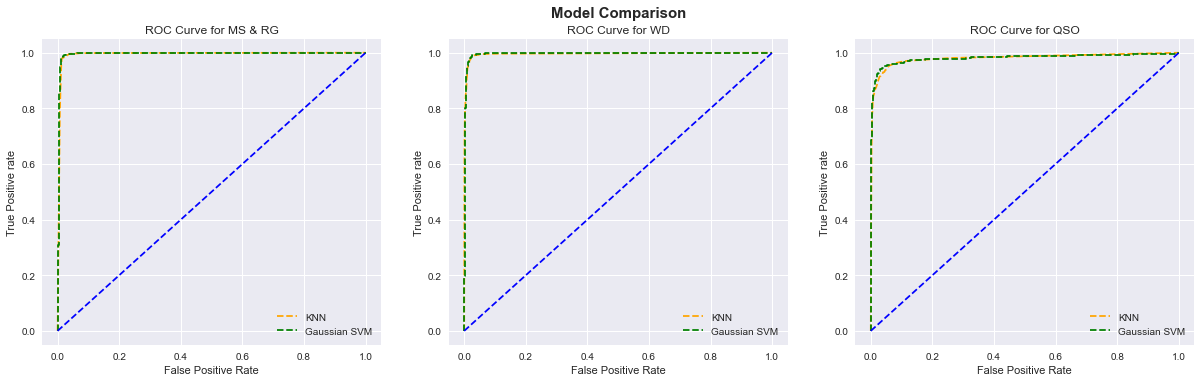

In [23]:
plt.style.use('seaborn')

fig= plt.figure(figsize=(20,5)) # Defines figure size

fig.subplots_adjust(left=0.1, right=0.90, bottom=0.05,top=0.9, wspace=0.2) # Defines subplot spacing

fig.suptitle('Model Comparison', y=0.99, fontsize=15, fontweight='bold')

class_names = ['MS & RG', 'WD', 'QSO']

j = 1

for i in range(3):
    ax = fig.add_subplot(1,3,j) # identifies location of subplot
    ax.plot(fpr1[i], tpr1[i], linestyle='--',color='orange', label='KNN')
    ax.plot(fpr2[i], tpr2[i], linestyle='--',color='green', label='Gaussian SVM')
    ax.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    # title
    ax.set_title('ROC Curve for ' + class_names[i])
    # x label
    ax.set_xlabel('False Positive Rate')
    # y label
    ax.set_ylabel('True Positive rate')

    ax.legend(loc='best')
    j+=1

In [25]:
# auc scores
auc_score1 = roc_auc_score(Y_test, pred_prob1, multi_class='ovr')
auc_score2 = roc_auc_score(Y_test, pred_prob2, multi_class='ovr')

print(auc_score1, auc_score2)

0.9897627697815823 0.9903424582319923


In [28]:
# Splits test set by classes
wd_index = np.where(test['class']==2)
quasar_index = np.where(test['class']==3)
test1 = test.iloc[0:wd_index[0][0]] # dataset with MS and red giants only
test2 = test.iloc[wd_index[0][0]:quasar_index[0][0]] # dataset with white dwarfs only
test3 = test.iloc[quasar_index[0][0]:quasar_index[0][-1]+1] # dataset with quasars only

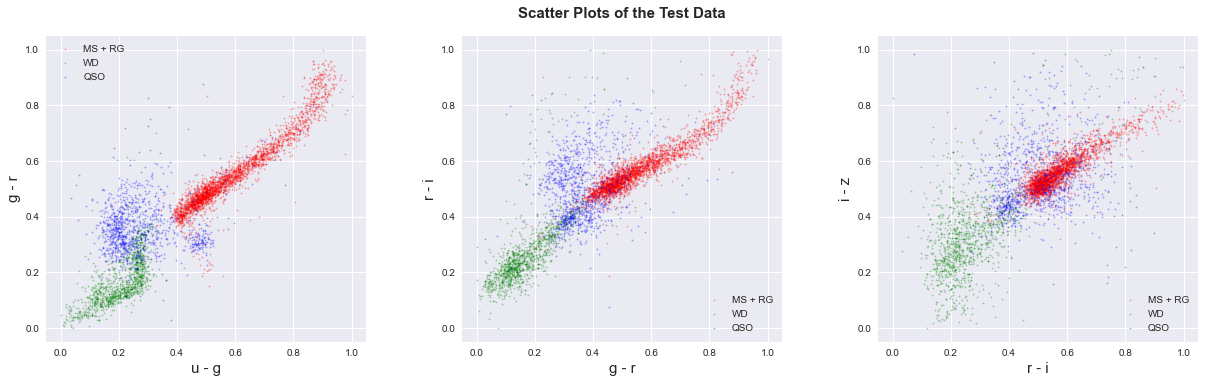

In [29]:
color_indices = ['u - g', 'g - r', 'r - i', 'i - z']
fig= plt.figure(figsize=(20,5)) # Defines figure size

fig.subplots_adjust(left=0.1, right=0.90, bottom=0.05,top=0.9, wspace=0.3) # Defines subplot spacing

fig.suptitle('Scatter Plots of the Test Data', fontsize=15, fontweight='bold')

j = 1

for i in range(3):
    ax = fig.add_subplot(1,3,j) # identifies location of subplot
    ax.scatter(test1[color_indices[i]], test1[color_indices[i+1]], s=2.0, c='r', alpha=0.3)
    ax.scatter(test2[color_indices[i]], test2[color_indices[i+1]], s=2.0, c='g', alpha=0.3)
    ax.scatter(test3[color_indices[i]], test3[color_indices[i+1]], s=2.0, c='b', alpha=0.3)

    ax.set_xlabel(color_indices[i], fontsize=15)
    ax.set_ylabel(color_indices[i+1], fontsize=15)
    ax.legend(['MS + RG', 'WD', 'QSO'])
    ax.grid(True)
    j+=1

In [34]:
# Gaussian SVM Predictions
Y_pred_Gauss = svc_Gauss.predict(X_test)
predictions = pd.DataFrame(Y_pred_Gauss, columns=['class'])
pred_data = pd.concat([X_test, predictions], axis=1)
pred_data.sort_values(by=['class'], axis=0, inplace=True)

In [35]:
# Splits test set by classes based on class values predicted by Gaussian SVM 
wd_index = np.where(pred_data==2)
quasar_index = np.where(pred_data==3)
test1 = test.iloc[0:wd_index[0][0]] # dataset with MS and red giants only
test2 = test.iloc[wd_index[0][0]:quasar_index[0][0]] # dataset with white dwarfs only
test3 = test.iloc[quasar_index[0][0]:quasar_index[0][-1]+1] # dataset with quasars only

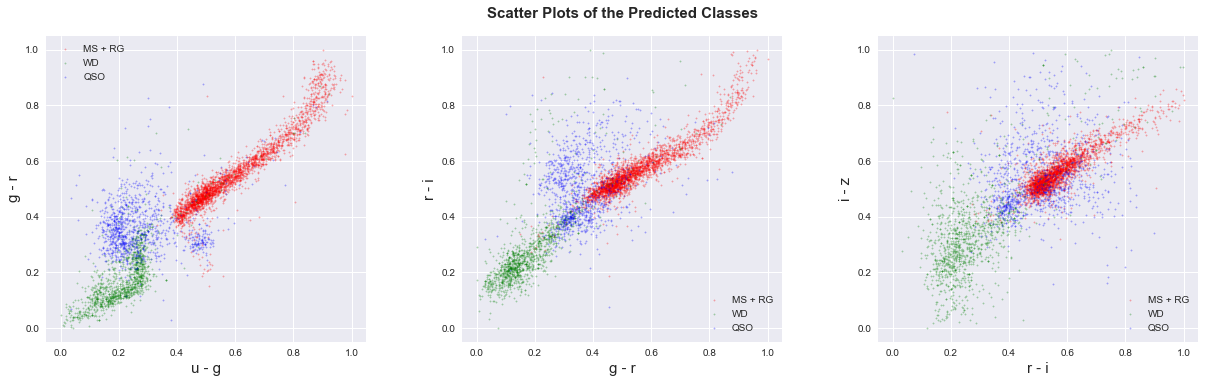

In [36]:
fig= plt.figure(figsize=(20,5)) # Defines figure size

fig.subplots_adjust(left=0.1, right=0.90, bottom=0.05,top=0.9, wspace=0.3) # Defines subplot spacing

fig.suptitle('Scatter Plots of the Predicted Classes', fontsize=15, fontweight='bold')

j = 1

for i in range(3):
    ax = fig.add_subplot(1,3,j) # identifies location of subplot
    ax.scatter(test1[color_indices[i]], test1[color_indices[i+1]], s=2.0, c='r', alpha=0.3)
    ax.scatter(test2[color_indices[i]], test2[color_indices[i+1]], s=2.0, c='g', alpha=0.3)
    ax.scatter(test3[color_indices[i]], test3[color_indices[i+1]], s=2.0, c='b', alpha=0.3)

    ax.set_xlabel(color_indices[i], fontsize=15)
    ax.set_ylabel(color_indices[i+1], fontsize=15)
    ax.legend(['MS + RG', 'WD', 'QSO'])
    ax.grid(True)
    j+=1